In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymongo import MongoClient
import datetime

In [2]:
timeSeriesCountData = pd.DataFrame(columns=['symbol','date','count'])

In [3]:
client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['mph']
collection_agg = db['token_aggs']

In [4]:
agg_data = collection_agg.find({'symbol':'LINK'})

In [5]:
index1 = 0

for agg_detail in agg_data:
    timeSeriesCountData.loc[index1, 'symbol'] = agg_detail['symbol']
    timeSeriesCountData.loc[index1,'date']= datetime.datetime.strptime(str(agg_detail['date']),'%Y%m%d')
    timeSeriesCountData.loc[index1, 'count'] = agg_detail['count'] # nomarlization
    index1+=1

In [6]:
timeSeriesCountData = timeSeriesCountData.sort_values(['date'])

In [7]:
startDate1 = "2018-03-02"
endDate1 = "2019-12-04"

startDate = datetime.datetime.strptime(startDate1,"%Y-%m-%d")
endDate = datetime.datetime.strptime(endDate1,"%Y-%m-%d")

monthDate = startDate +pd.DateOffset(months=3)

In [8]:
timeSeriesCountData1 = timeSeriesCountData.loc[(timeSeriesCountData['date'] >= startDate) & (timeSeriesCountData['date'] <= endDate), :]

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


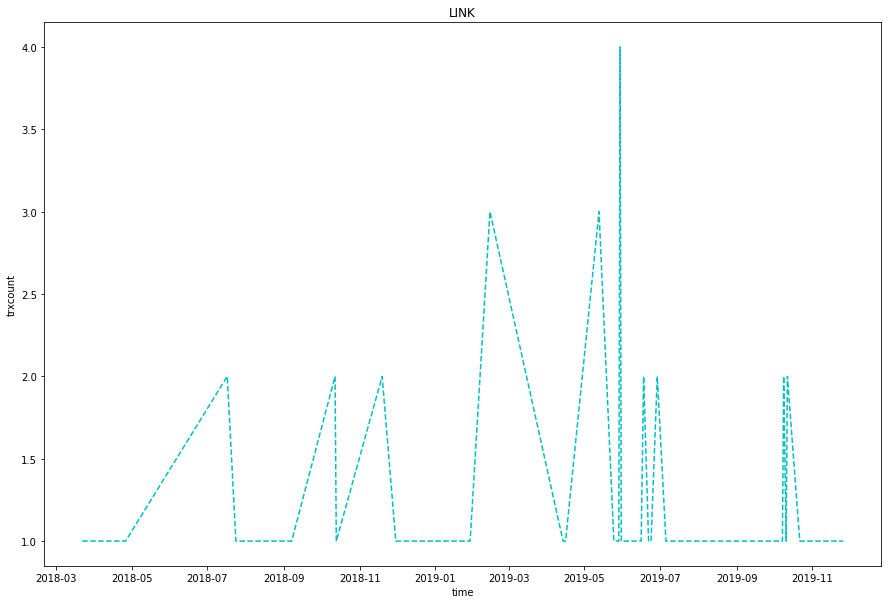

In [9]:
plt.figure(figsize=(15,10))
plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['count'].values, 'c--')
plt.title("LINK")
plt.xlabel('time')
plt.ylabel('trxcount')
plt.show()

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


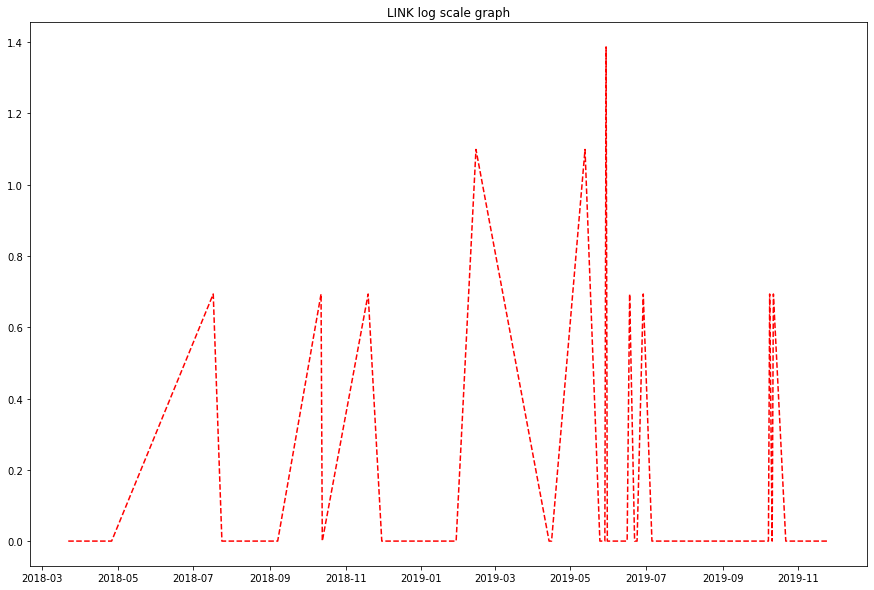

In [10]:
plt.figure(figsize=(15,10))
timeSeriesCountData1['log_count'] = np.log(np.array(timeSeriesCountData1['count'],dtype=np.float32))

plt.plot(timeSeriesCountData1['date'].values, timeSeriesCountData1['log_count'].values, 'r--')
plt.title('LINK log scale graph')
plt.show()

In [13]:
from sklearn.cluster import KMeans
X = timeSeriesCountData1[['log_count']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=3)
km.fit(X)
km.predict(X)
labels = km.labels_

In [14]:
labels

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0], dtype=int32)

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


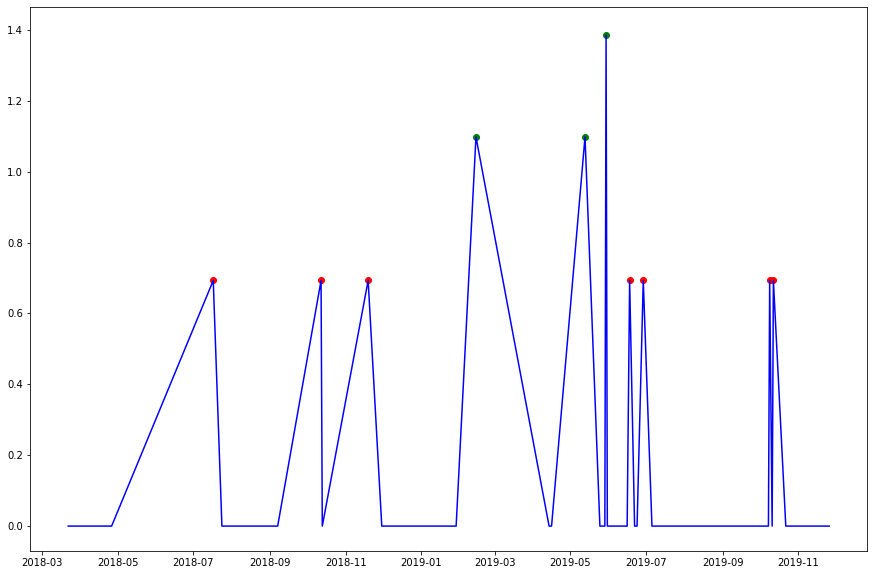

In [16]:
timeSeriesCountData1['label']=labels
fig1, bx = plt.subplots(figsize=(15,10))
b = timeSeriesCountData1.loc[timeSeriesCountData1['label'] == 1, ['date', 'log_count']] #anomaly
c = timeSeriesCountData1.loc[timeSeriesCountData1['label'] == 2, ['date', 'log_count']] #anomaly
bx.plot(timeSeriesCountData1['date'], timeSeriesCountData1['log_count'], color='blue')
bx.scatter(b['date'],b['log_count'], color='red')
bx.scatter(c['date'],c['log_count'], color='green')

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
scaler = StandardScaler()

In [18]:
timeSeriesCountData1['index'] = timeSeriesCountData1.index
data = timeSeriesCountData1[['index','log_count']]
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
model = OneClassSVM(nu=0.001,kernel="rbf",gamma=0.00001)
model.fit(data)

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-05, kernel='rbf',
            max_iter=-1, nu=0.001, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [19]:
timeSeriesCountData1['anomaly'] = pd.Series(model.predict(data))

/Users/hongminpyo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


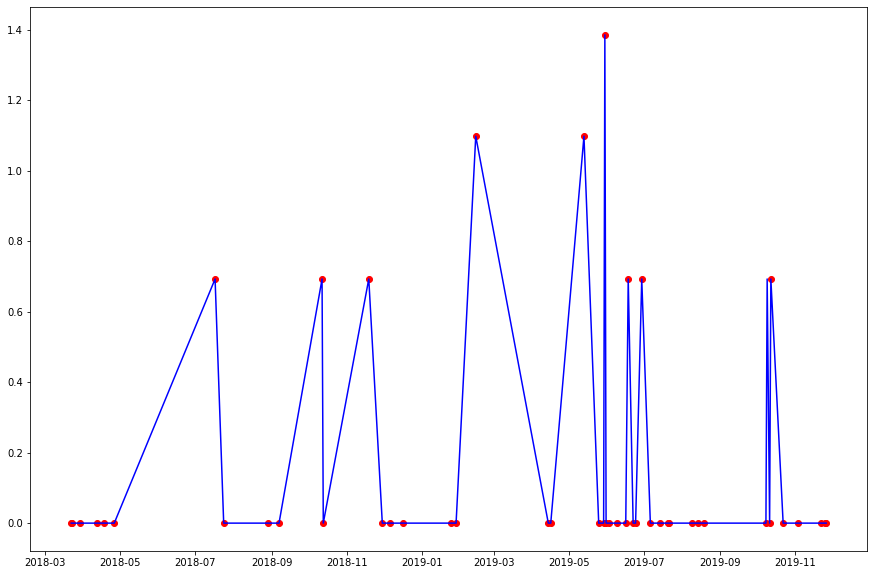

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
a = timeSeriesCountData1.loc[timeSeriesCountData1['anomaly'] == -1, ['date', 'log_count']] #anomaly
ax.plot(timeSeriesCountData1['date'], timeSeriesCountData1['log_count'], color='blue')
ax.scatter(a['date'],a['log_count'], color='red')